# Multi-Task Optimization Across Ceramic Binder Systems

Tape casting is a manufacturing technique for producing thin, uniform ceramic components that find applications in fuel cells, batteries, and capacitors. The fabrication process involves casting a thin ceramic slurry over a flat sheet using a doctor blade, a drying process, and then debinding and sintering.

You are interesting in fabricating casting some thin, but robust ceramic membranes for use in a hydrogen fuel cell. Green strength appears to be an important factor so you decide to target this metric. After working through the literature you identify the following key slurry components and the likely ranges.

| Component | WT% Range  |
|-----------|------------|
| Ceramic Powder | 50-70 |
| Solvent        | 20-30 |
| Binder         | 10-20 |
| Plasticizer    | 0-1   |

You identify two possible binder systems (A, B) and request samples from the manufacturers. For Binder A you recieve enough binder sample to perform 20 experimental trials. However, for Binder B you only receive enough to perform 10 experimental trials. You would like to give each binder system a fair assessment, but are worried that 10 experimental trials might not be enough to to find an optimal formulation.

To compensate the small sample size, the Binder B manufacturer provided recommended formulation, which is listed below in weight percents of components:

```python
{
    "ceram_frac": 0.62, 
    "solv_frac": 0.3,
    "binder_frac": 0.1,
    "plast_frac": 0.01
}
```

You suspect that there will be a lot of commonality between the optimal formulations regardless of binder, and believe that a multi-task optimization approach the shares information between the two systems could help offset the lack of data for Binder B.

A set of dummy objective functions has been constructed in the code cell below to emulate the results of experimental trials under different inputs and biner systems. Although we can easily find the optimal values using the equation, we will pretend that the objective function is unknown and use a Bayesian optimization approach to find the optimal set of input parameters instead.

In [1]:
import numpy as np

def gauss(x, mean, std):
    return np.exp(-(((x - mean) / std) ** 2))

def strength_binderA(ceram_frac, solv_frac, binder_frac, plast_frac, task='A'):
    """Return the green strength of tape cast samples made with binder A"""

    sigma = (
        gauss(ceram_frac, 0.6, 0.1) + gauss(solv_frac, 0.23, 0.2)
        + gauss(binder_frac, 0.15, 0.05) + gauss(plast_frac, 0.005, 0.01)
    )

    return 3.8 * sigma

def strength_binderB(ceram_frac, solv_frac, binder_frac, plast_frac, task='B'):
    """Return the green strength of tape cast samples made with binder B"""

    sigma = (
        gauss(ceram_frac, 0.55, 0.07) + gauss(solv_frac, 0.26, 0.15)
        + gauss(binder_frac, 0.14, 0.03) + gauss(plast_frac, 0.007, 0.01)
    )

    return 4.0 * sigma

## Applying Honegumi

We will now use the [Honegumi](https://honegumi.readthedocs.io/en/latest/index.html) website to generate a script that will help us optimze both binder systems using multi-task optimization. From the description, we observe that our problem is a **single objective** problem with **two tasks**. As the maufacturer gave us a suggested composition, we also have some **existing data** to include in the model.

![Honegumi Selections for Multitask Optimization](multitask_selection.png)

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# MOD:` has been added along with a brief description of the change.

In [ ]:
import numpy as np
from ax.core.observation import ObservationFeatures
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.modelbridge.transforms.task_encode import TaskEncode
from ax.modelbridge.transforms.unit_x import UnitX
from ax.service.ax_client import AxClient, ObjectiveProperties

transforms = [TaskEncode, UnitX]

gs = GenerationStrategy(
    name="MultiTaskOp",
    steps=[
        GenerationStep(
            model=Models.SOBOL,
            num_trials=8,
            model_kwargs={"deduplicate": True, "transforms": transforms},
        ),
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,
            model_kwargs={"transforms": transforms},
        ),
    ],
)

ax_client = AxClient(generation_strategy=gs, random_seed=42, verbose_logging=False)

ax_client.create_experiment(
    name="MultiTaskOp",
    parameters=[
        {"name": "ceram_frac",  "type": "range", "bounds": [0.5, 0.7]},
        {"name": "solv_frac",   "type": "range", "bounds": [0.2, 0.3]},
        {"name": "binder_frac", "type": "range", "bounds": [0.1, 0.2]},
        {"name": "plast_frac",  "type": "range", "bounds": [0.0, 0.01]},
        {
            "name": "task",
            "type": "choice",
            "values": ["A", "B"],
            "is_task": True,
            "target_value": "B"
        },
    ],
    objectives={"Objective": ObjectiveProperties(minimize=False)},
)

# append the manufacturer suggestion
parameterization = {"ceram_frac": 0.62, "solv_frac": 0.3, "binder_frac": 0.1, "plast_frac": 0.01, "task": "B"}
ax_client.attach_trial(parameterization)
ax_client.complete_trial(trial_index=0, raw_data={"Objective": strength_binderB(**parameterization)})

for i in range(20+10-1):
    p, trial_index = ax_client.get_next_trial(
        fixed_features=ObservationFeatures({"task": "A" if i < 20 else "B"})
    )

    if p["task"] == "A":
        sigma = strength_binderA(p["ceram_frac"], p["solv_frac"], p["binder_frac"], p["plast_frac"])
    else:
        sigma = strength_binderB(p["ceram_frac"], p["solv_frac"], p["binder_frac"], p["plast_frac"])

    ax_client.complete_trial(trial_index=trial_index, raw_data={"Objective": sigma})

> NOTE: The output of the above cell has been hidden in the interest of clarity.

[WARNING 08-15 16:31:08] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


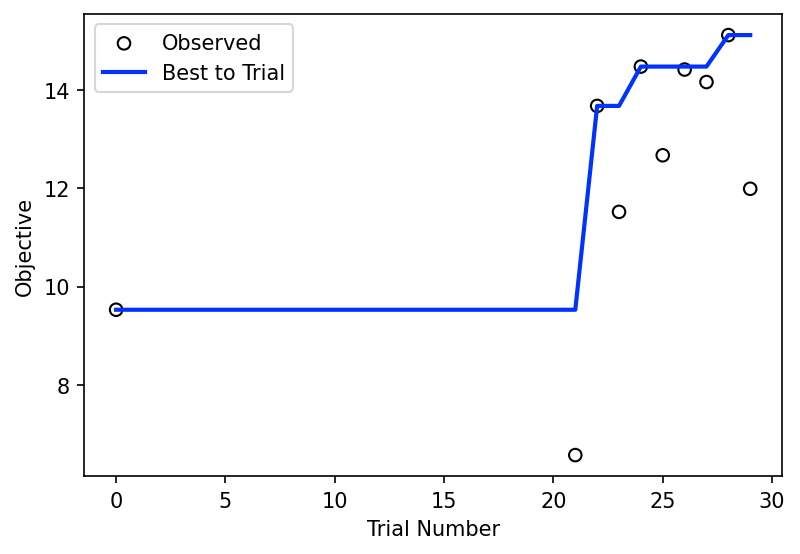

In [118]:
import matplotlib.pyplot as plt

task = "B"  # specify task results to plot

objectives = ax_client.objective_names
objectives.extend(["task"])
df = ax_client.get_trials_data_frame()[objectives]
df = df[df.task == task].drop(columns=["task"])

best_to_trial = np.maximum.accumulate(df) # MOD: set to maximum

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(df.index, df, ec="k", fc="none", label="Observed")
ax.plot(best_to_trial, color="#0033FF", lw=2, label="Best to Trial")
ax.set_xlabel("Trial Number")
ax.set_ylabel(objectives[0])
ax.legend()
plt.show()

## Did Using the Multitask Model Help?

We might be curious to see whether the use of a multi-task GP helped in this scenario. To validate our decision, we can test what would have happened if we tried to optimize the Binder B ceramic formulation in isolation. Below we have generated a simple script to perform this. In the interest of brevity we exclude the honegumi selection details and changes.

In [132]:
import numpy as np
from ax.service.ax_client import AxClient, ObjectiveProperties

obj1_name = "strength"

gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.SOBOL,
            num_trials=4,
        ),
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,
        ),
    ]
)

ax_client = AxClient(generation_strategy=gs, verbose_logging=False, random_seed=42)

ax_client.create_experiment(
    parameters=[
        {"name": "ceram_frac",  "type": "range", "bounds": [0.5, 0.7]},
        {"name": "solv_frac",   "type": "range", "bounds": [0.2, 0.3]},
        {"name": "binder_frac", "type": "range", "bounds": [0.1, 0.2]},
        {"name": "plast_frac",  "type": "range", "bounds": [0.0, 0.01]},
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=False),
    },
)

parameterization = {"ceram_frac": 0.62, "solv_frac": 0.3, "binder_frac": 0.1, "plast_frac": 0.01}
ax_client.attach_trial(parameterization)
ax_client.complete_trial(trial_index=0, raw_data={obj1_name: strength_binderB(**parameterization)})

for _ in range(6-1):

    parameterization, trial_index = ax_client.get_next_trial()

    sigma = strength_binderB(p["ceram_frac"], p["solv_frac"], p["binder_frac"], p["plast_frac"])

    ax_client.complete_trial(trial_index=trial_index, raw_data=sigma)

best_parameters, metrics = ax_client.get_best_parameters()

print("\nisolated optimal strength:", metrics[0]['strength'])

[WARNING 08-15 16:42:17] ax.service.ax_client: Random seed set to 42. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 08-15 16:42:17] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ceram_frac. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 08-15 16:42:17] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter solv_frac. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 08-15 16:42:17] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for param


isolated optimal strength: 11.98660869461255


It seems that we did benefit from using the multi-task approach!

## Next Steps

Interested in taking this further? Try to implement the following on your own!

1. What if we had ignored the manufacturer and instead plugged the optimal value from the optimization of the Binder A system as the initial Binder B system point? Would that have improved our optimization performance?

2. We waited to optimize the Binder B system until we finished the Binder A system, but what if we had interspersed the Binder B trials and attempted a Binder B trial every two Binder A trials. Would that have helped or hurt our performance?